## Analyze trials

In [325]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
from concise.hyopt import CompileFN, CMongoTrials, test_fn
import numpy as np
import pandas as ps
from keras.models import load_model
import sklearn.metrics as skm
import concise.eval_metrics as cem
import keras.callbacks as kc
import data
import model
from helper import *

DB_NAME = "Concise__Splice_branchpoints"
exp_name = "model_deep"


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [281]:
trials = CMongoTrials(DB_NAME, exp_name, kill_timeout=30 * 60)

In [282]:
df = trials.as_df().sort_values("eval.auprc", ascending=False)
df.head(7)

,tid,loss,status,eval.accuracy,eval.auc,eval.auprc,eval.f1,eval.fdr,eval.loss,eval.precision,eval.sensitivity,eval.specificity,name.data,name.loss_metric,name.loss_metric_mode,name.model,param.data.n_bases,param.data.pos_class_weight,param.data.truncate,param.fit.batch_size,param.fit.early_stop_monitor,param.fit.epochs,param.fit.patience,param.model.filters,param.model.init_motifs,param.model.lr,param.model.nonlinearity,param.model.pos_effect.l2,param.model.pos_effect.l2_smooth,param.model.pos_effect.merge.hidden_fc.activation,param.model.pos_effect.merge.hidden_fc.dropout_rate,param.model.pos_effect.merge.hidden_fc.n_hidden,param.model.pos_effect.merge.hidden_fc.n_layers,param.model.pos_effect.merge.type,param.model.pos_effect.n_bases,param.model.pos_effect.use_bias,path.model,path.results,time.duration.dataload,time.duration.total,time.duration.training,time.end,time.start
589,1704,-0.6795,ok,0.9617,0.9481,0.6795,0.5824,0.2187,0.1087,0.7813,0.4701,0.9919,data,auprc,auprc,model,30,2.0,True,128,val_loss,150,4,120,None,0.0018,relu,0,1.8044e-13,relu,0.2222,70,2,concatenate,30,False,/s/project/deepcis/hy...,/s/project/deepcis/hy...,55.4963,285.6366,230.1403,2017-05-01 10:03:18.1...,2017-05-01 09:58:32.5...
939,2058,-0.6794,ok,0.9619,0.9472,0.6794,0.5873,0.2207,0.1098,0.7793,0.4768,0.9917,data,auprc,auprc,model,30,2.0,True,128,val_loss,150,4,120,None,0.0009,relu,0,6.5912e-16,relu,0.3178,70,2,concatenate,30,False,/s/project/deepcis/hy...,/s/project/deepcis/hy...,55.8533,429.8302,373.9769,2017-05-01 15:47:45.9...,2017-05-01 15:40:36.1...
599,1718,-0.6792,ok,0.9616,0.9476,0.6792,0.5804,0.2171,0.1080,0.7829,0.4660,0.9920,data,auprc,auprc,model,30,2.0,True,128,val_loss,150,4,120,None,0.0026,relu,0,1.2122e-13,relu,0.2681,70,2,concatenate,30,False,/s/project/deepcis/hy...,/s/project/deepcis/hy...,56.2211,307.0460,250.8249,2017-05-01 10:09:05.5...,2017-05-01 10:03:58.4...
443,1525,-0.6792,ok,0.9613,0.9486,0.6792,0.5546,0.1787,0.1094,0.8213,0.4238,0.9943,data,auprc,auprc,model,30,2.0,True,128,val_loss,150,4,120,None,0.0021,relu,0,8.7263e-18,relu,0.4771,70,2,concatenate,30,False,/s/project/deepcis/hy...,/s/project/deepcis/hy...,56.4571,310.3179,253.8608,2017-05-01 00:17:33.0...,2017-05-01 00:12:22.7...
909,2028,-0.6792,ok,0.9619,0.9482,0.6792,0.5877,0.2187,0.1081,0.7813,0.4762,0.9918,data,auprc,auprc,model,30,2.0,True,128,val_loss,150,4,120,None,0.0006,relu,0,6.2145e-15,relu,0.3107,70,2,concatenate,30,False,/s/project/deepcis/hy...,/s/project/deepcis/hy...,56.4162,407.3404,350.9241,2017-05-01 11:38:03.1...,2017-05-01 11:31:15.7...
732,1851,-0.6792,ok,0.9617,0.9478,0.6792,0.5751,0.2064,0.1090,0.7936,0.4562,0.9927,data,auprc,auprc,model,20,2.0,True,128,val_loss,150,4,120,None,0.0020,relu,0,3.7560e-15,relu,0.3347,70,2,concatenate,20,False,/s/project/deepcis/hy...,/s/project/deepcis/hy...,77.4000,417.1731,339.7730,2017-05-01 10:48:09.9...,2017-05-01 10:41:12.8...
413,1495,-0.6791,ok,0.9615,0.9483,0.6791,0.5861,0.2304,0.1095,0.7696,0.4781,0.9912,data,auprc,auprc,model,30,2.0,True,128,val_loss,150,4,120,None,0.0015,relu,0,1.4277e-15,relu,0.4504,70,2,concatenate,30,False,/s/project/deepcis/hy...,/s/project/deepcis/hy...,88.1476,450.1160,361.9684,2017-05-01 00:10:01.0...,2017-05-01 00:02:30.9...


In [263]:
TID = 1704

In [264]:
model_path = df[df["tid"] == TID]["path.model"].iloc[0]
m = load_model(model_path)

In [265]:
param = trials.get_param(TID).to_dict()
param

{'data': {'n_bases': 30, 'pos_class_weight': 2.0, 'truncate': True},
 'fit': {'batch_size': 128,
  'early_stop_monitor': 'val_loss',
  'epochs': 150,
  'patience': 4},
 'model': {'filters': 120,
  'init_motifs': None,
  'lr': 0.0018083393108468257,
  'nonlinearity': 'relu',
  'pos_effect': {'l2': 0,
   'l2_smooth': 1.8043779896824148e-13,
   'merge': {'hidden_fc': {'activation': 'relu',
     'dropout_rate': 0.22224175847973257,
     'n_hidden': 70,
     'n_layers': 2},
    'type': 'concatenate'},
   'n_bases': 30,
   'use_bias': False}}}

In [299]:
param["data"]["truncate"] = False  #  this version was ran ignoring the truncate value
train, test = data.data(**param["data"])

In [300]:
train[0]["dist1"].shape

(28042, 27, 30)

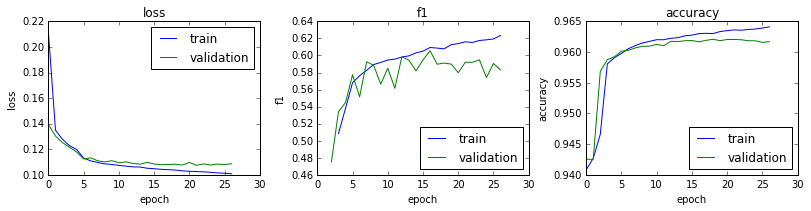

In [290]:
plot_history(trials, TID)

In [269]:
m.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
seq (InputLayer)                 (None, 37, 4)         0                                            
____________________________________________________________________________________________________
dist1 (InputLayer)               (None, 27, 30)        0                                            
____________________________________________________________________________________________________
dist2 (InputLayer)               (None, 27, 30)        0                                            
____________________________________________________________________________________________________
ppt_start (InputLayer)           (None, 27, 30)        0                                            
___________________________________________________________________________________________

## Model performance

In [270]:
from concise.utils.model_data import split_train_test_idx, subset

train_idx, valid_idx = split_train_test_idx(train, valid_split=.2, stratified=False, random_state=100)

valid = subset(train, valid_idx, keep_other=False)
train_train = subset(train, train_idx)

In [351]:
metrics_dt(m, {"train": train_train, "valid": valid, "test": test})

,dataset,loss,acc,f1,precision,sensitivity,sensitivity,specificity,fdr,auprc,auc
0,test,0.1066,0.9327,0.5615,0.7364,0.4586,0.4586,0.9906,0.2636,0.6508,0.9477
1,valid,0.1087,0.9332,0.5824,0.7813,0.4701,0.4701,0.9919,0.2187,0.6795,0.9481
2,train,0.0977,0.9355,NaN,NaN,0.5059,0.5059,0.9930,NaN,0.7274,0.9592


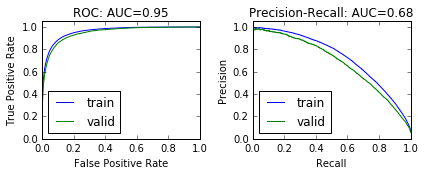

In [350]:
plot_roc_pr(m, [train_train, valid], ["train", "valid"])

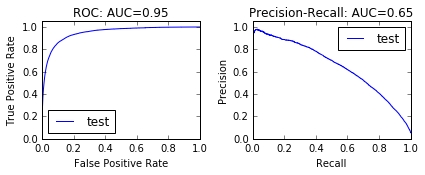

In [328]:
data = plot_roc_pr(m, [test], ["test"], return_data=True)
y_true, y_pred = data[0]

## Export predictions to csv

In [329]:
dt_pred = pd.DataFrame({"y_true": y_true.reshape((-1,)), "y_pred": y_pred.reshape((-1,))})
dt_pred = dt_pred[dt_pred["y_true"] != -1]
dt_pred["y_true"] = np.where(dt_pred["y_true"]== 1, "HC", "NEG")
dt_pred.sort_values("y_pred")

,y_pred,y_true
88908,2.4367e-18,NEG
88904,3.1727e-18,NEG
88909,4.9674e-18,NEG
...,...,...
82239,9.9352e-01,HC
74217,9.9406e-01,HC
147375,9.9686e-01,NEG


In [280]:
dt_pred.to_csv("/s/project/deepcis/Concise/Splice_branchpoints/test_predictions/concise_deep.csv")

## Plot positional dependence

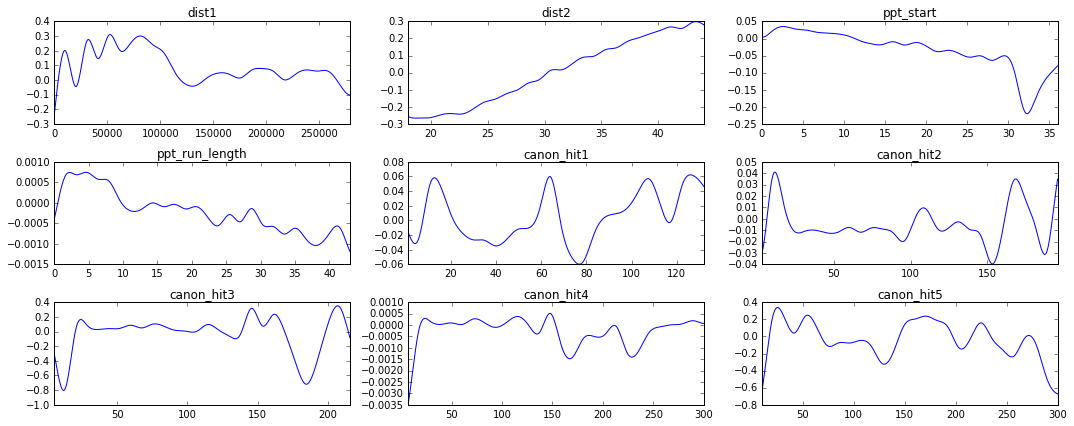

In [308]:
dfpos = plot_pos_dep(m, param, train)

In [309]:
dfpos

,feature,x,y
0,dist1,-20.0000,-0.2350
1,dist1,259.1512,-0.2161
2,dist1,538.3023,-0.1973
...,...,...,...
997,canon_hit5,299.4194,-0.6693
998,canon_hit5,299.7097,-0.6708
999,canon_hit5,300.0000,-0.6723
